In [1]:
%matplotlib inline

# Forward simulation

Here we perform a simple toy forward simulation without scattering (only absorption) to determine the photon survival probabilities in a simpler binning scheme.

Let's define binning as plane-polar with a time axis and a polar angle $\phi_{\rm dir}$ for directionality.

In [2]:
from __future__ import division, print_function

from copy import deepcopy
from itertools import product
from os.path import expanduser, expandvars, join
import sys
from time import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pisa import ureg
from pisa.core.binning import OneDimBinning

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


In [3]:
retro_dir = expanduser(expandvars('~/src/retro'))
if retro_dir not in sys.path:
    sys.path.append(retro_dir)

In [4]:
from retro import mkdir, powerspace, pol2cart
from retro.toy_sim import (
    sgnstar,
    pick_nonzero_bin,
    forward_survival_prob,
    retro_point_dom_survival_prob,
    retro_finite_dom_survival_prob
)

In [5]:
outdir = 'toy_sim_test_methodology'
mkdir(outdir)

Define physical constants and parameters

In [6]:
speed_of_light = 299792458 # m/s
absorption_length = 1 # m

Define binning for table

In [7]:
r_binning = OneDimBinning(
    name='r',
    bin_edges=powerspace(0, 400, 101, 2),
    units='m'
)
phi_binning = OneDimBinning(
    name='phi',
    tex=r'\phi',
    domain=(0, 2*np.pi),
    is_lin=True,
    num_bins=80,
    units='rad'
)
t_binning = OneDimBinning(
    name='t',
    domain=(0, 3000),
    is_lin=True,
    num_bins=250,
    units='ns'
)
phidir_binning = OneDimBinning(
    name='phidir',
    tex=r'\phi_{\rm dir}',
    domain=(0, 2*np.pi),
    is_lin=True,
    num_bins=160,
    units='rad'
)
binning = r_binning * phi_binning * t_binning * phidir_binning
binning

MultiDimBinning([
    OneDimBinning('r', 100 irregularly-sized bins with edges at [0.0, 0.04000000000000001, 0.16000000000000003, 0.3600000000000001, 0.6400000000000001, 1.0, 1.4400000000000004, 1.9600000000000004, 2.5600000000000005, 3.24, 4.0, 4.840000000000001, 5.760000000000002, 6.760000000000001, 7.840000000000002, 9.0, 10.240000000000002, 11.560000000000002, 12.96, 14.440000000000001, 16.0, 17.64, 19.360000000000003, 21.160000000000004, 23.040000000000006, 25.0, 27.040000000000003, 29.160000000000004, 31.360000000000007, 33.64000000000001, 36.0, 38.440000000000005, 40.96000000000001, 43.56000000000001, 46.24000000000001, 49.0, 51.84, 54.760000000000005, 57.760000000000005, 60.84000000000001, 64.0, 67.24000000000002, 70.56, 73.96, 77.44000000000001, 81.0, 84.64000000000001, 88.36000000000001, 92.16000000000003, 96.04000000000002, 100.0, 104.04000000000002, 108.16000000000001, 112.36000000000003, 116.64000000000001, 121.0, 125.44000000000003, 129.96, 134.56000000000003, 139.24, 144

In [8]:
sp = binning.zeros(name='survival_prob')
np.product(binning.shape)
np.product(binning.num_bins)

320000000

Define the DOM (centered at origin)

In [9]:
dom_radius = 0.165 # m
dom_circumference = 2*np.pi * dom_radius # m
dom_area = np.pi * dom_radius**2 # m^2
dom_efficiency = 1.0 # perfect detector

Define forward-sim photon initial conditions

In [14]:
# Pick a bin that will have non-zero entries
r0 = r_binning.midpoints[int((r_binning.num_bins * 1) // 2)].m_as('m') # m
dr = r0 - dom_radius # m
t0 = dr / speed_of_light * 1e9 # ns
phi0 = phi_binning.midpoints[0].m_as('rad') # rad
phidir0 = (phi0 + np.pi) % (2*np.pi)

bin_edges = tuple(be.m for be in binning.bin_edges)
h, _ = np.histogramdd(np.array([[r0, phi0, t0, phidir0]]), bins=bin_edges, normed=False)
indices0 = tuple(c[0] for c in np.where(h == 1))
r0_idx, phi0_idx, t0_idx, phidir0_idx = indices0

# offset the directionality by some # of bins
phidir0_idx += 1

indices0 = r0_idx, phi0_idx, t0_idx, phidir0_idx
bin0 = binning[indices0]
bin0_edges = tuple(q.m for q in bin0.bin_edges)
r0_edges, phi0_edges, t0_edges, phidir0_edges = bin0_edges
print('indices of bin0 in table:', indices0)
print('bin0:\n{}'.format(bin0))
print(bin0_edges)
print(r0_edges, phi0_edges)

indices of bin0 in table: (50, 0, 28, 82)
bin0:
MultiDimBinning(
    OneDimBinning('r', 1 bin with edges at [100.0, 104.04000000000002] m (behavior is linear)),
    OneDimBinning('phi', 1 bin with edges at [0.0, 0.07853981633974483] rad (behavior is linear)),
    OneDimBinning('t', 1 bin with edges at [336.0, 348.0] ns (behavior is linear)),
    OneDimBinning('phidir', 1 bin with edges at [3.220132469929538, 3.25940237809941] rad (behavior is linear))
)
(array([100.  , 104.04]), array([0.        , 0.07853982]), array([336., 348.]), array([3.22013247, 3.25940238]))
[100.   104.04] [0.         0.07853982]


In [15]:
# Since we chose the first phi bin, sampling uniformly is "easy" in this region via rejection sampling
xmin = np.min(r0_edges) * np.cos(np.max(phi0_edges))
xmax = np.max(r0_edges)
dx = xmax - xmin
ymin = 0
ymax = np.max(r0_edges) * np.sin(np.max(phi0_edges))
dy = ymax - ymin
print('x lims: [{}, {})'.format(xmin, xmax))
print('y lims: [{}, {})'.format(ymin, ymax))

x lims: [99.6917333733, 104.04)
y lims: [0, 8.16288431952)


In [16]:
seed = 0
n_photons_forward_sim = int(1e7)

rand = np.random.RandomState(seed)
x_samples = rand.uniform(low=xmin, high=xmax, size=n_photons_forward_sim*2)
y_samples = rand.uniform(low=ymin, high=ymax, size=n_photons_forward_sim*2)
r_samples = np.hypot(x_samples, y_samples)
phi_samples = np.arctan(y_samples / x_samples)

rbi = np.digitize(r_samples, bins=r0_edges)
pbi = np.digitize(phi_samples, bins=phi0_edges)
inside_mask = (
    (rbi > 0) & (rbi <= 1)
    &
    (pbi > 0) & (pbi <= 1)
)
x_samples = x_samples[inside_mask][:n_photons_forward_sim]
y_samples = y_samples[inside_mask][:n_photons_forward_sim]
r_samples = r_samples[inside_mask][:n_photons_forward_sim]
phi_samples = phi_samples[inside_mask][:n_photons_forward_sim]

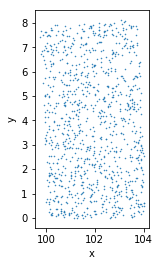

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_samples[:1000], y_samples[:1000], marker='.', s=1)
ax.axis('image')
ax.set_xlabel('x')
ax.set_ylabel('y')

fpath_base = join(outdir, 'mc_samples')
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

$\phi_{\rm dir}$ can be sampled directly from uniform distribution, and since all photons start a the DOM at "$t=0$" in Retro, we take the time to come directly from the pathlength.

In [18]:
phidir_samples = rand.uniform(low=phidir0_edges[0], high=phidir0_edges[1], size=n_photons_forward_sim)

Test for intersection with the circular DOM.
See http://mathworld.wolfram.com/Circle-LineIntersection.html

In [19]:
ray_distance = 100 # m
dom_radius_sq = dom_radius**2

dx = ray_distance * np.cos(phidir_samples)
dy = ray_distance * np.sin(phidir_samples)
endpt_x = x_samples + dx
endpt_y = y_samples + dy
determinant = x_samples * endpt_y - endpt_x * y_samples
dr_sq = dx**2 + dy**2
discriminant = dom_radius_sq * dr_sq - determinant**2

In [20]:
# select out only values that intersect the DOM
mask = discriminant >= 0
num_hits = mask.sum()
print('Number of photons that hit DOM in any t-bin (and at any angle of incidence):', num_hits)
x = np.compress(mask, x_samples)
y = np.compress(mask, y_samples)
dx = np.compress(mask, dx)
dy = np.compress(mask, dy)
endpt_x = np.compress(mask, endpt_x)
endpt_y = np.compress(mask, endpt_y)
determinant = np.compress(mask, determinant)
dr_sq = np.compress(mask, dr_sq)
discriminant = np.compress(mask, discriminant)

Number of photons that hit DOM in any t-bin (and at any angle of incidence): 4197


In [21]:
sqrt_discr = np.sqrt(discriminant)

det_dy = determinant * dy
neg_det_dx = - determinant * dx
sgnstar_dx_sqrt_discr = sgnstar(dy) * dx * sqrt_discr
abs_dy_sqrt_discr = np.abs(dy) * sqrt_discr

x0_int = (det_dy + sgnstar_dx_sqrt_discr) / dr_sq
x1_int = (det_dy - sgnstar_dx_sqrt_discr) / dr_sq

y0_int = (neg_det_dx + abs_dy_sqrt_discr) / dr_sq
y1_int = (neg_det_dx - abs_dy_sqrt_discr) / dr_sq

In [22]:
dist0sq = (x - x0_int)**2 + (y - y0_int)**2
dist1sq = (x - x1_int)**2 + (y - y1_int)**2
mask = dist0sq < dist1sq

In [23]:
distsq = np.where(mask, dist0sq, dist1sq)
x_int = np.where(mask, x0_int, x1_int)
y_int = np.where(mask, y0_int, y1_int)

Now select only those points that fall within the time bin

In [24]:
dist = np.sqrt(distsq)
transit_time = dist / speed_of_light * 1e9 # ns

mask = (transit_time >= t0_edges[0]) & (transit_time < t0_edges[1])

num_hits = np.sum(mask)
print('Number of photons that hit DOM and fall in the t-bin (at any angle of incidence):',
      num_hits)

x = np.compress(mask, x)
y = np.compress(mask, y)
dx = np.compress(mask, dx)
dy = np.compress(mask, dy)
endpt_x = np.compress(mask, endpt_x)
endpt_y = np.compress(mask, endpt_y)
dist = np.compress(mask, dist)
distsq = np.compress(mask, distsq)
x_int = np.compress(mask, x_int)
y_int = np.compress(mask, y_int)

Number of photons that hit DOM and fall in the t-bin (at any angle of incidence): 3336


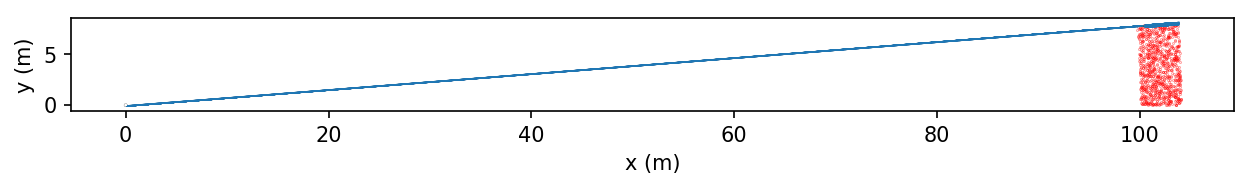

In [26]:
lines = mpl.collections.LineCollection(
    zip(zip(x[:1000], y[:1000]), zip(x_int[:1000], y_int[:1000])),
    linewidths=0.01
)
dom_patch = mpl.patches.Circle(
    xy=(0, 0), radius=dom_radius,
    facecolor='none', edgecolor='k', lw=0.1, zorder=-1
)

fig = plt.figure(figsize=(10, 8), dpi=150)
ax = fig.add_subplot(111)
ax.scatter(x_samples[:1000], y_samples[:1000], marker='.', color='r', s=0.1)
ax.add_patch(dom_patch)
ax.add_collection(lines)
ax.scatter(x[:1000], y[:1000], marker='.', s=0.2)
ax.axis('image')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

fpath_base = join(outdir, 'fwd_sim_1k_photon_paths')
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

In [27]:
pdet = np.sum(dom_efficiency * np.exp(-dist / absorption_length)) / n_photons_forward_sim
bin_geometric_norm = num_hits / n_photons_forward_sim

In [28]:
print(
    '{:.2e} of {:.2e} photons ({}%) actually struck the DOM (at any angle of incidence);\n'
    '  (this should be the geometric norm for the bin in Retro)'
    .format(num_hits, n_photons_forward_sim, np.round(num_hits/n_photons_forward_sim*100, 5))
)
print('phi bin subtends {}% of a full circle'.format(np.round(100*np.diff(phi0_edges/(2*np.pi))[0], 3)))
print('phi_dir bin subtends {}% of a full circle'.format(np.round(100*np.diff(phidir0_edges/(2*np.pi))[0], 3)))
print('Probability of the DOM detecting a photon with parameters within the chosen bin: {:.3e}'.format(pdet))

3.34e+03 of 1.00e+07 photons (0.03336%) actually struck the DOM (at any angle of incidence);
  (this should be the geometric norm for the bin in Retro)
phi bin subtends 1.25% of a full circle
phi_dir bin subtends 0.625% of a full circle
Probability of the DOM detecting a photon with parameters within the chosen bin: 1.778e-48


## Is the center of mass point indicative?

In [29]:
# TODO

## Can we analytically derive $P_{\rm surv}$?

In [30]:
# TODO

# Reverse simulation

Let's repeat the above experiment, but as we do in Retro (right now at least) and see if we can fiure out the survival probability in the same bin displayed above.

This means we simulate light originating at the DOM (or rather at the origin to replicate exactly what we do now) and directed radially outwards.

In [31]:
n_photons_simple_retro_sim = int(1e6)

rand = np.random.RandomState(seed + 1)
retro_phi_samples = rand.uniform(low=0, high=2*np.pi, size=n_photons_simple_retro_sim)
retro_phidir_samples = (retro_phi_samples + np.pi) % (2*np.pi)
mask_phi = (retro_phi_samples >= phi0_edges[0]) & (retro_phi_samples < phi0_edges[1])
mask_phidir = (retro_phidir_samples >= phidir0_edges[0]) & (retro_phidir_samples < phidir0_edges[1])
mask = mask_phi & mask_phidir

retro_num_hits = np.sum(mask)
print('Retro number of photons in the bin = {} ({} pass phi bin crit., {} pass phidir bin crit.)'
      .format(retro_num_hits, np.sum(mask_phi), np.sum(mask_phidir)))

retro_phi_samples = np.compress(mask, retro_phi_samples)
retro_phidir_samples = np.compress(mask, retro_phidir_samples)

Retro number of photons in the bin = 0 (12354 pass phi bin crit., 6204 pass phidir bin crit.)


Each photon will be divided into `stepLength` chunks (starting at a random offset) and counted some number of times within the bin.
We'll simulate that here.

In [32]:
step_length = 0.5 # m

radial_samples_r0 = rand.uniform(low=r0_edges[0], high=r0_edges[0] + step_length, size=retro_num_hits)
radial_samples = []
r_kept = 0
t_kept = 0
for r_step_idx in range(int((r0_edges[1] - r0_edges[0]) // step_length)):
    rsamp = radial_samples_r0 + r_step_idx * step_length
    mask = rsamp < r0_edges[1]
    r_kept += np.sum(mask)
    rsamp = np.compress(mask, rsamp)
    tsamp = rsamp / speed_of_light * 1e9 # ns
    mask = (tsamp >= t0_edges[0]) & (tsamp < t0_edges[1])
    t_kept += np.sum(mask)
    radial_samples.append(np.compress(mask, rsamp))
print('r_kept = {}, t_kept = {}'.format(r_kept, t_kept))
radial_samples = np.concatenate(radial_samples)

r_kept = 0, t_kept = 0


Now to tabulate the survival probability in the bin...

In [33]:
unnormed_retro_pdet = np.sum(dom_efficiency * np.exp(-radial_samples / absorption_length))

n_photons = n_photons_simple_retro_sim

t_bin_length = (np.diff(t0_edges)[0] / 1e9) * speed_of_light
r_bin_length = np.diff(r0_edges)[0]
limiting_bin_length = min(t_bin_length, r_bin_length)

current_retro_norm = (
    1 / n_photons
    / (t_bin_length / step_length)
    * (2*np.pi / np.diff(phi0_edges)[0])
)

jll_norm = (
    1 / n_photons
    / (limiting_bin_length / step_length)
    * (2*np.pi / np.diff(phi0_edges)[0])
)

pde_norm = (
    1 / (n_photons * (speed_of_light / 1e9 * t_bin_length / step_length) * np.mean(r0_edges))
)

jvs_norm = ( # stepLength * DOM area / bin volume
    1 / n_photons
    * step_length * 2 * np.pi * dom_radius / (np.diff(phi0_edges)[0] * 0.5 * (r0_edges[1]**2 - r0_edges[0]**2)) # * np.diff(phidir0_edges)[0] * np.diff(t0_edges)[0])
)

counts_per_photon = limiting_bin_length / step_length

r0_, r1_ = bin0.r.bin_edges.m_as('m')
phi0_, phi1_ = bin0.phi.bin_edges.m_as('rad')
dphi_ = (phi1_ - phi0_) % (2*np.pi)
phidir0_, phidir1_ = bin0.phidir.bin_edges.m_as('rad')
dphidir_ = (phidir1_ - phidir0_) % (2*np.pi)
s_avg = (phi1_ - phi0_) * (r0_ + r1_) / 2

directional_aperture_angle = bin0.phidir.bin_widths[0].m_as('rad')
directional_aperture_area = 0.5 * (r0_ + r1_) * directional_aperture_angle
directional_aperture_norm = directional_aperture_angle / (2*np.pi)

cell_aeff = 0.5 * (r0_ + r1_) * bin0.phi.bin_widths[0].m_as('rad')
cell_aeff = (
    # TODO: The "onside" edge is not sensitive since
    # the directionality points towards center... should we include it?
    (r0_ + r1_) * bin0.phi.bin_widths[0].m_as('rad')
    
    # Each side is also sensitive, so include these, too
    + 2 * bin0.r.bin_widths[0].m_as('m')
)

dom_aeff = dom_circumference
print('dom_aeff: ', dom_aeff)
print('cell_aeff:', cell_aeff)

#aeff_norm = dom_circumference / directional_aperture_area if dom_circumference < directional_aperture_area else 1
aeff_norm = dom_circumference / cell_aeff if dom_circumference < cell_aeff else 1
print('aeff_norm:', aeff_norm, '\n')

geometrically_expected_photons_in_bin = n_photons * (np.diff(phi0_edges)[0] / (2*np.pi))
geometrically_expected_samples_in_bin = geometrically_expected_photons_in_bin * counts_per_photon

jll2_norm = (
    1 / geometrically_expected_samples_in_bin
    * directional_aperture_norm
)

jll3_norm = (
    1 / geometrically_expected_samples_in_bin
    * bin_geometric_norm
)

alpha = np.arctan(
    (dom_radius / np.mean(r0_edges)) / (1 + np.tan(dphi_ / 2) / np.tan(dphidir_ / 2))
)
theor_bin_geometric_norm = alpha / (dphidir_ / 2)
jll4_norm = (
    1 / geometrically_expected_samples_in_bin
    * theor_bin_geometric_norm
)


print('Forward sim pdet:         {:.3e}'.format(pdet))
print()
norms = [
    ('current', current_retro_norm),
    ('jll', jll_norm),
    ('pde', pde_norm),
    ('jvs', jvs_norm),
    ('jll2', jll2_norm),
    ('jll3', jll3_norm),
    ('jll4', jll4_norm),
]
for name, norm in norms:
    val = norm * unnormed_retro_pdet
    print(
        'Retro pdet, {:7s} norm: {:.3e} ({:+6.1f}% error, nval/truth={:.3e}, truth/nval={:.3e})'
        .format(name, val, (val - pdet)/pdet*100, val/pdet, pdet/val)
    )

AttributeError: 'numpy.float64' object has no attribute 'm_as'

# Reverse simulation from finite DOM

So we get close, but is the error due to an incorrect normalziation, or due to the use of photons not emanating from the DOM in any but the radial direction?

To find out, let's simulate photons emanating from the surface of the DOM with angles $\in [-\pi, +\pi]$ from the DOM normal at the photon generation point.

In [34]:
%%time

n_photons_finite_retro_sim = int(1e6)

rand = np.random.RandomState(seed + 1)
start_phi_samp = rand.uniform(low=0, high=2*np.pi, size=n_photons_finite_retro_sim)
phidir_samp = (start_phi_samp + rand.uniform(low=-np.pi/2, high=np.pi/2, size=n_photons_finite_retro_sim)) % (2*np.pi)
#start_phi_samp = rand.uniform(low=phi0_edges[0], high=phi0_edges[1], size=n_photons_finite_retro_sim)
#phidir_samp = (start_phi_samp + rand.uniform(low=-np.pi/2/1000, high=np.pi/2/1000, size=n_photons_finite_retro_sim)) % (2*np.pi)

x0 = dom_radius * np.cos(start_phi_samp)
y0 = dom_radius * np.sin(start_phi_samp)

displ_first_samp = rand.uniform(low=0, high=step_length, size=n_photons_finite_retro_sim)
displ_samp_offsets = np.arange(0, 2*dom_radius + r0_edges[1] + step_length, step_length)
displ_samp = np.add.outer(displ_samp_offsets, displ_first_samp)

x_samp = x0 + displ_samp * np.cos(phidir_samp)
y_samp = y0 + displ_samp * np.sin(phidir_samp)

# need polar coords relative to origin to find what's inside the binning
r_samp = np.hypot(x_samp, y_samp)
t_samp = displ_samp / (speed_of_light / 1e9)
phi_samp = np.arctan2(y_samp, x_samp)

# duplicate phidir for each point
phidir_samp = np.stack([phidir_samp]*len(displ_samp_offsets))

[   ERROR] Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/justin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/justin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/justin/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/justin/anaconda2/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/justin/anaconda2/lib/python2.7/inspect.py", line 1013, in getframeinfo
    lines, lnum = findsource(frame)
  File "/home/justin/anaconda2/lib/python2.7/site-packages/IPy

IndexError: string index out of range

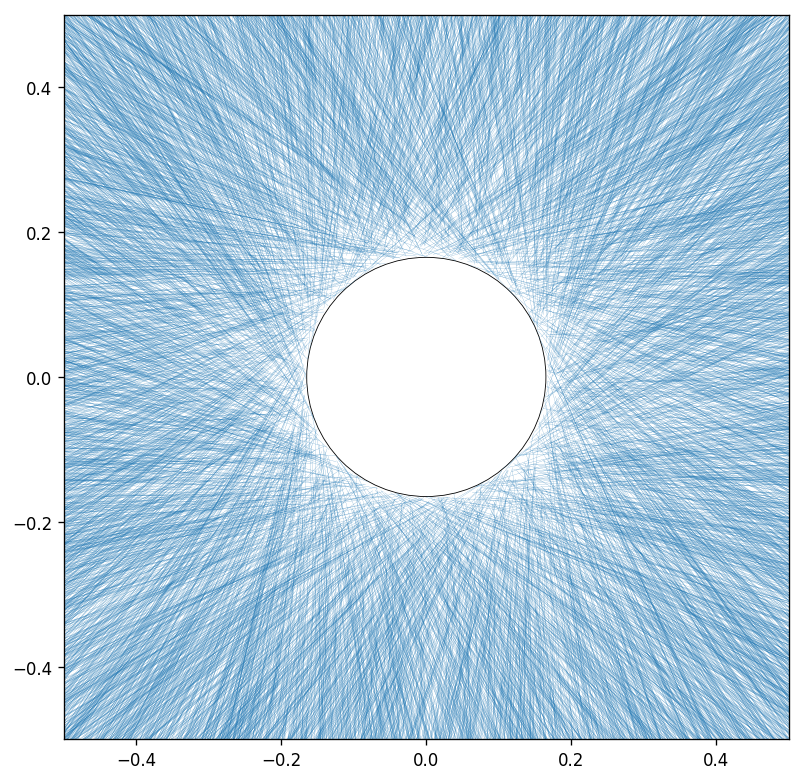

In [38]:
n_disp = 10000
lines = mpl.collections.LineCollection(
    segments=zip(zip(x_samp[0, :n_disp], y_samp[0, :n_disp]), zip(x_samp[-1, :n_disp], y_samp[-1, :n_disp])),
    linewidths=0.1
)
dom_patch = mpl.patches.Circle(
    xy=(0, 0), radius=dom_radius,
    facecolor='none', edgecolor='k', lw=0.5, 
)

fig, ax = plt.subplots(1,1,figsize=(10, 8), dpi=120)
#ax.scatter(x_samp.flatten(), y_samp.flatten(), s=0.02)
ax.add_collection(lines)
ax.add_patch(dom_patch)
lim = 0.5
ax.axis('image')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

fpath_base = join(outdir, 'retro_fin_sim_1k_photon_paths')
fig.savefig(fpath_base + '.pdf')
fig.savefig(fpath_base + '.png')

pass

In [31]:
(phidir0_edges + np.pi) % (2*np.pi)

array([ 0.06544985,  0.13089969])

In [32]:
%%time

hist, edges = np.histogramdd(
    (r_samp.flatten(), t_samp.flatten(), phi_samp.flatten(), phidir_samp.flatten()),
    bins=(r0_edges, t0_edges, phi0_edges, (phidir0_edges + np.pi) % (2*np.pi)),
    weights=dom_efficiency * np.exp(-displ_samp.flatten() / absorption_length)
)
unnormed_retro2_pdet = float(hist.squeeze())
print(unnormed_retro2_pdet)

30.6992948398
CPU times: user 1.51 s, sys: 256 ms, total: 1.76 s
Wall time: 1.76 s


In [33]:
n_photons = n_photons_finite_retro_sim

t_bin_length = (np.diff(t0_edges)[0] / 1e9) * speed_of_light
r_bin_length = np.diff(r0_edges)[0]
limiting_bin_length = min(t_bin_length, r_bin_length)

current_retro_norm = (
    1 / n_photons
    / (t_bin_length / step_length)
    * (2*np.pi / np.diff(phi0_edges)[0])
)

jll_norm = (
    1 / n_photons
    / (limiting_bin_length / step_length)
    * (2*np.pi / np.diff(phi0_edges)[0])
)

pde_norm = (
    1 / (n_photons * (speed_of_light / 1e9 * t_bin_length / step_length)  * np.mean(r0_edges))
)

jvs_norm = ( # stepLength * DOM area / bin volume
    1 / n_photons
    * step_length * 2*np.pi * dom_radius / (np.diff(phi0_edges)[0] * 1/2*(r0_edges[1]**2 - r0_edges[0]**2) * np.diff(phidir0_edges)[0] * np.diff(t0_edges)[0])
)

counts_per_photon = limiting_bin_length / step_length

r0_, r1_ = bin0.r.bin_edges.m_as('m')
phi0_, phi1_ = bin0.phi.bin_edges.m_as('rad')
dphi_ = (phi1_ - phi0_) % (2*np.pi)
phidir0_, phidir1_ = bin0.phidir.bin_edges.m_as('rad')
dphidir_ = (phidir1_ - phidir0_) % (2*np.pi)
s_avg = (phi1_ - phi0_) * (r0_ + r1_) / 2

directional_aperture_angle = bin0.phidir.bin_widths[0].m_as('rad')
directional_aperture_area = 0.5 * (r0_ + r1_) * directional_aperture_angle

directional_aperture_norm = directional_aperture_angle / (2*np.pi)

#cell_aeff = 0.5 * (r0_ + r1_) * bin0.phi.bin_widths[0].m_as('rad')
# "Area" of the cell is just its perimeter length (in 2D)
cell_aeff = (
    # "Front" and "back" (curved) edges of the bin
    (r0_ + 0*r1_) * bin0.phi.bin_widths[0].m_as('rad')

    # Each side is also sensitive, so include these
    + 2 * bin0.r.bin_widths[0].m_as('m')
)

# "Area" of the DOM is just its circumference (in 2D)
dom_aeff = dom_circumference
print('dom_aeff: ', dom_aeff)
print('cell_aeff:', cell_aeff)

#aeff_norm = dom_circumference / directional_aperture_area if dom_circumference < directional_aperture_area else 1
aeff_norm = dom_circumference / cell_aeff if dom_circumference < cell_aeff else 1
print('aeff_norm:', aeff_norm, '\n')

geometrically_expected_photons_in_bin = n_photons * (np.diff(phi0_edges)[0] / (2*np.pi))
geometrically_expected_samples_in_bin = counts_per_photon * geometrically_expected_photons_in_bin

jll2_norm = 1 / geometrically_expected_samples_in_bin * directional_aperture_norm
jll3_norm = 1 / geometrically_expected_samples_in_bin * bin_geometric_norm

alpha = np.arctan(
    (dom_radius / np.mean(r0_edges)) / (1 + np.tan(dphi_ / 2) / np.tan(dphidir_ / 2))
)
theor_bin_geometric_norm = alpha / (dphidir_ / 2)
jll4_norm = 1 / geometrically_expected_samples_in_bin * theor_bin_geometric_norm

print('Forward sim pdet:         {:.3e}'.format(pdet))
print()
norms = [
    ('current', current_retro_norm),
    ('jll', jll_norm),
    ('pde', pde_norm),
    ('jvs', jvs_norm),
    ('jll2', jll2_norm),
    ('jll3', jll3_norm),
    ('jll4', jll4_norm)
]
for name, norm in norms:
    val = norm * unnormed_retro2_pdet
    print(
        'Retro pdet, {:7s} norm: {:.3e} ({:+10.4f}% error, nval/truth={:.5e}, truth/nval={:.5e})'
        .format(name, val, (val - pdet)/pdet*100, val/pdet, pdet/val)
    )

dom_aeff:  1.03672557568
cell_aeff: 3.1780972451
aeff_norm: 0.326209519638 

Forward sim pdet:         3.746e-04

Retro pdet, current norm: 1.638e-04 (  -56.2581% error, nval/truth=4.37419e-01, truth/nval=2.28614e+00)
Retro pdet, jll     norm: 4.912e-04 (  +31.1350% error, nval/truth=1.31135e+00, truth/nval=7.62573e-01)
Retro pdet, pde     norm: 2.628e-06 (  -99.2985% error, nval/truth=7.01478e-03, truth/nval=1.42556e+02)
Retro pdet, jvs     norm: 1.905e-05 (  -94.9140% error, nval/truth=5.08605e-02, truth/nval=1.96616e+01)
Retro pdet, jll2    norm: 5.117e-06 (  -98.6340% error, nval/truth=1.36599e-02, truth/nval=7.32070e+01)
Retro pdet, jll3    norm: 1.109e-04 (  -70.3838% error, nval/truth=2.96162e-01, truth/nval=3.37654e+00)
Retro pdet, jll4    norm: 9.505e-05 (  -74.6247% error, nval/truth=2.53753e-01, truth/nval=3.94083e+00)


In [34]:
print('"correct" norm:          ', pdet / unnormed_retro2_pdet * geometrically_expected_samples_in_bin)
print('bin_geometric_norm (MC): ', bin_geometric_norm)
phi_norm = np.diff(phi0_edges)[0] / (2*np.pi)
print('phi_norm:                ', phi_norm)
print('phidir_norm:             ', directional_aperture_norm)
print('theor_bin_geometric_norm:', theor_bin_geometric_norm)

"correct" norm:           0.762572949407
bin_geometric_norm (MC):  0.2258448
phi_norm:                 0.03125
phidir_norm:              0.0104166666667
theor_bin_geometric_norm: 0.193505492807


To really test the normalization, we should simulate several (or many) bins of different sizes and distances from the DOM.

See `toy_sim_test_normaliztion.ipynb` for doing exactly that.